In [105]:
import sys
IN_COLAB = "google.colab" in sys.modules
if not IN_COLAB:
    !pip install gymnasium==1.0.0

In [106]:
import subprocess
subprocess.check_call(['pip', 'install', 'gymnasium[classic_control]'])

0

In [107]:
import os
import copy
import random
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
from IPython.display import clear_output

In [108]:
class ReplayBuffer:
    def __init__(self, obs_dim: int, act_dim: int, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size, act_dim], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros([size], dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size = 0, 0
    
    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray,
        rew: float,
        next_obs: np.ndarray,
        done: bool,
    ):
        """ Store the transition in buffer """
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        """ Randomly sample a batch of experiences from memeory """
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False) # replace=False --> No duplicate
        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews = self.rews_buf[idxs],
            done=self.done_buf[idxs],
        )

    def __len__(self) -> int:
        return self.size

In [109]:
class OUNoise:
    def __init__(self, size: int, mu: float=0.0, theta: float=0.15, sigma: float=0.2):
        self.state = np.float64(0.0)
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()
    
    def reset(self):
        """ Reset the internal state (= noise) to mean (mu) """
        self.state = copy.copy(self.mu)
    
    def sample(self) -> np.ndarray:
        """ Update internal state and return it as a noise sample """
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array(
            [random.random() for _ in range(len(x))]
        )
        self.state = x + dx
        return self.state

In [110]:
class Actor(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, init_w: float=3e-3):
        super(Actor, self).__init__()

        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, out_dim)

        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)
    
    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """ Forward method implementation """
        x = F.relu(self.hidden1(state)) # relu negative values to 0, positive values as they are
        x = F.relu(self.hidden2(x))
        action = self.out(x).tanh() # ranged between -1 and 1

        return action

class Critic(nn.Module):
    def __init__(self, in_dim: int, init_w: float=3e-3):
        super(Critic, self).__init__()

        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)

        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        """ Forward method implementation """
        x = torch.cat((state, action), dim=1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        value = self.out(x)

        return value

In [111]:
class DDPGAgent:
    """DDPGAgent interacting with environment.

    Attribute:
        env (gym.Env): openAI Gym environment
        actor (nn.Module): target actor model to select actions
        actor_target (nn.Module): actor model to predict next actions
        actor_optimizer (Optimizer): optimizer for training actor
        critic (nn.Module): critic model to predict state values
        critic_target (nn.Module): target critic model to predict state values
        critic_optimizer (Optimizer): optimizer for training critic
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        gamma (float): discount factor
        tau (float): parameter for soft target update
        initial_random_steps (int): initial random action steps
        noise (OUNoise): noise generator for exploration
        device (torch.device): cpu / gpu
        transition (list): temporory storage for the recent transition
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
        seed (int): random seed
    """
    def __init__(
        self, 
        env: gym.Env, 
        memory_size: int, 
        batch_size: int,
        ou_noise_theta: float,
        ou_noise_sigma: float,
        gamma: float = 0.99,
        tau: float = 5e-3,
        initial_random_steps: int = 1e4,
        seed: int = 777,
    ):
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]

        self.env = env
        self.memory = ReplayBuffer(obs_dim, action_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.initial_random_steps = initial_random_steps
        self.seed = seed

        # noise
        self.noise = OUNoise(
            action_dim,
            theta=ou_noise_theta,
            sigma=ou_noise_sigma,
        )

        # device: cpu / gpu
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)

        # networks
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())

        self.critic = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        # transition to store in memory
        self.transition = list()

        # total steps count
        self.total_step = 0

        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """ Select an action from the input state """
        # if initial random action should be conducted
        if self.total_step < self.initial_random_steps and not self.is_test:
            selected_action = self.env.action_space.sample()
        else:
            selected_action = (
                self.actor(torch.FloatTensor(state).to(self.device)).detach().cpu().numpy()
            )

        # add noise for exploration during training
        if not self.is_test:
            noise = self.noise.sample()
            selected_action = np.clip(selected_action + noise, -1.0, 1.0)
        
        self.transition = [state, selected_action]

        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """ Take an action and return the response of the env """
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)
        
        return next_state, reward, done
    
    def update_model(self) -> torch.Tensor:
        """ Update the model by gradient descent """
        device = self.device

        samples = self.memory.sample_batch()
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.FloatTensor(samples["acts"]).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        masks = 1 - done
        next_action = self.actor_target(next_state)
        next_value = self.critic_target(next_state, next_action)
        curr_return = reward + self.gamma * next_value * masks

        # train critic
        values = self.critic(state, action)
        critic_loss = F.mse_loss(values, curr_return)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # train actor
        actor_loss = -self.critic(state, self.actor(state)).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # target update
        self._target_soft_update()

        return actor_loss.data, critic_loss.data
    
    def train(self, num_frames: int, plotting_interval: int = 200):
        """ Train the agent """
        self.is_test = False
        
        state, _ = self.env.reset(seed=self.seed)
        actor_losses = []
        critic_losses = []
        scores = []
        score = 0

        for self.total_step in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:
                state, _ = self.env.reset(seed=self.seed)
                scores.append(score)
                score = 0
            
            # if training is ready
            if len(self.memory) >= self.batch_size and self.total_step > self.initial_random_steps:
                actor_loss, critic_loss = self.update_model()
                actor_losses.append(actor_loss.cpu().numpy())
                critic_losses.append(critic_loss.cpu().numpy())

            # plotting
            if self.total_step % plotting_interval == 0:
                self._plot(
                    self.total_step,
                    scores,
                    actor_losses,
                    critic_losses,
                )
        
        self.env.close()

    def test(self, video_folder: str):
        """ Test the agent """
        self.is_test = True

        tmp_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder)

        state, _ = self.env.reset(seed=self.seed)
        done = False
        score = 0
        
        while not done:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward 
        
        print("score: ", score)
        self.env.close()

        self.env = tmp_env 
    
    def _target_soft_update(self):
        """ Soft-update: target = tau*local + (1-tau)*target. """
        tau = self.tau

        for t_param, l_param in zip(self.actor_target.parameters(), self.actor.parameters()):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)

        for t_param, l_param in zip(self.critic_target.parameters(), self.critic.parameters()):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)

    def _plot(self, frame_idx: int, scores: List[float], actor_losses: List[float], critic_losses: List[float]):
        """ Plot the training progresses """

        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)
        
        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]

        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

In [112]:
class ActionNormalizer(gym.ActionWrapper):
    """ Rescale and relocate the actions """

    def action(self, action: np.ndarray) -> np.ndarray:
        """ Change the range (-1, 1) to (low, high) """
        low = self.action_space.low
        high = self.action_space.high 

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = action * scale_factor + reloc_factor
        action = np.clip(action, low, high)

        return action
    
    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """ Change the range (low, high) to (-1, 1) """ 
        low = self.action_space.low
        high = self.action_space.high 

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = (action - reloc_factor) / scale_factor
        action = np.clip(action, -1.0, 1.0)

        return action

In [113]:
# environment
env = gym.make("Pendulum-v1", render_mode="rgb_array")
env = ActionNormalizer(env)

In [114]:
# Set random seed

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

seed = 777
random.seed(seed)
np.random.seed(seed)
seed_torch(seed)

In [115]:
# initialize parameters

num_frames = 50000
memory_size = 100000
batch_size = 128
ou_noise_theta = 1.0
ou_noise_sigma = 0.1
initial_random_steps = 10000

agent = DDPGAgent(
    env,
    memory_size,
    batch_size,
    ou_noise_theta,
    ou_noise_sigma,
    initial_random_steps=initial_random_steps,
    seed=seed,
)

cpu


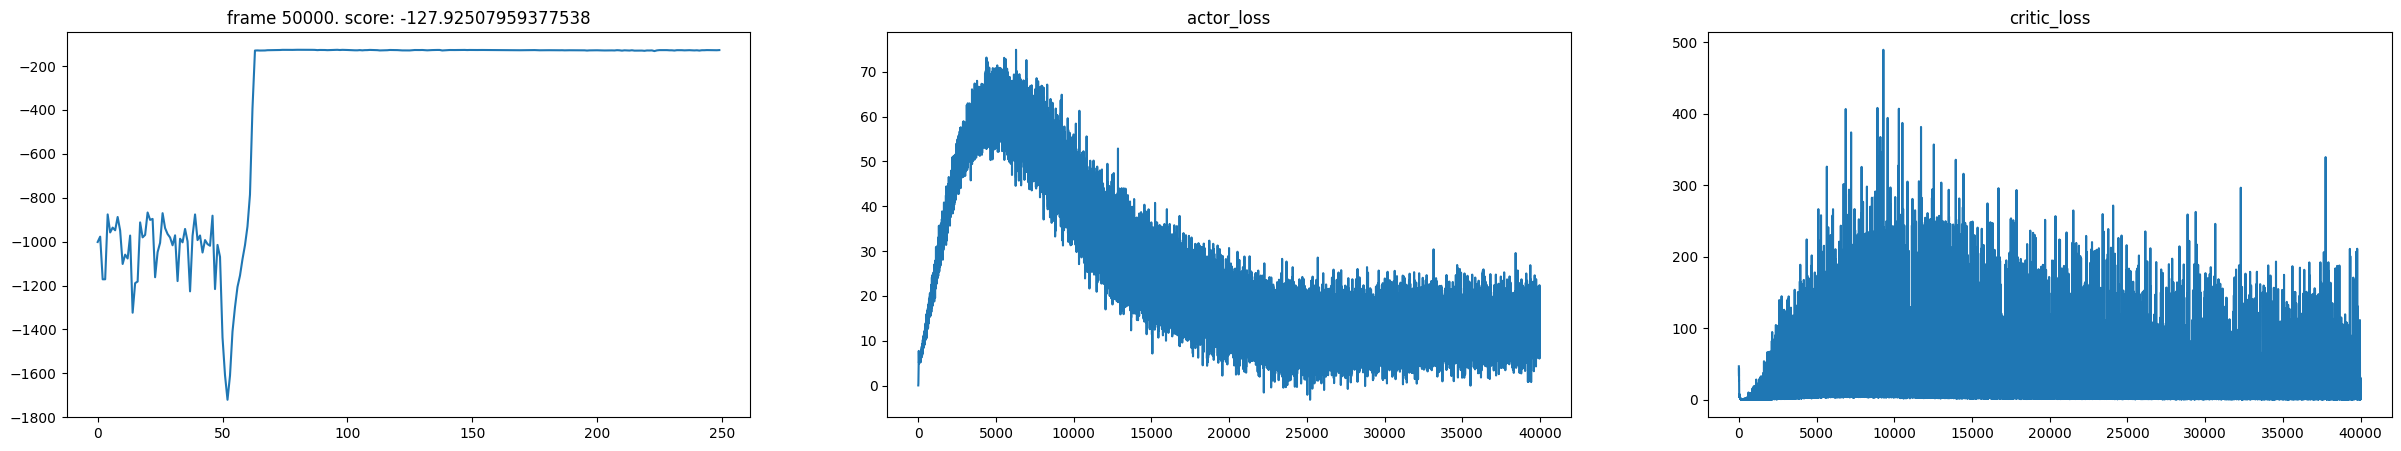

In [116]:
agent.train(num_frames)

In [117]:
# test
video_folder = "videos/ddpg"
os.makedirs(video_folder, exist_ok=True)
agent.test(video_folder=video_folder)

c:\Users\kevin\anaconda\envs\ai_project\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\kevin\Desktop\AI Projects (Spider Bot)\videos\ddpg folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  


score:  -129.09700555600168


In [118]:
import base64
import glob
import io
import os

from IPython.display import HTML, display


def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(
        HTML(
            data="""
        <video width="320" height="240" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(
                encoded.decode("ascii")
            )
        )
    )


def show_latest_video(video_folder: str) -> str:
    """Show the most recently recorded video from video folder."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    latest_file = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_file)
    return latest_file


latest_file = show_latest_video(video_folder=video_folder)
print("Played:", latest_file)

Played: videos/ddpg\rl-video-episode-0.mp4
